# Integration for Mouse Spleen data

## loading package

In [ ]:
import os
import dgl
import pandas as pd
import sys
import scanpy as sc
import importlib 
import torch as th
import torch.nn as nn
from sklearn.utils import shuffle
from model_integration import *

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
     "font.size":20,
    "axes.unicode_minus": False 
}
rcParams.update(config)

/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/xiangdw/MODEL


## Integration

In [2]:
import torch.nn.functional as F
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
import numpy as np
from model_integration import set_seed
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')


for i in range(1): 
    seeds = str(i+1)
    path = '/data/xiangdw/data/data/'
    adata_omics1 = sc.read_h5ad(path + 'adata_RNA_spots.h5ad')
    adata_omics2 = sc.read_h5ad(path + 'adata_ADT_spots.h5ad')

    adata_omics1.obs['batch'] = adata_omics1.obs['batch'].astype(str)
    adata_omics2.obs['batch'] = adata_omics2.obs['batch'].astype(str)

    set_seed(2024) 
    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, adata_omics1, adata_omics2 = Sagegraph(modalities, device, task='Integration', 
                                                                              datatype="spots",batch=True)

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]
    weight = [1,1,1]
    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='integration', datatype='spots',
                        layers_nums=int(3), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='mean', lr=2e-4, lr2 = 0.002)

    output  = model.fit( adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, weight_factors=[1,5,1,1])

    adata_omics2.obsm['SpaMIE'] = output[0].detach().cpu().numpy()
    

/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
2025-10-17 16:05:38,700 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-17 16:05:41,244 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-17 16:05:41,284 - harmonypy - INFO - Iteration 1 of 10
2025-10-17 16:05:42,828 - harmonypy - INFO - Iteration 2 of 10
2025-10-17 16:05:44,442 - harmonypy - INFO - Iteration 3 of 10
2025-10-17 16:05:46,008 - harmonypy - INFO - Iteration 4 of 10
2025-10-17 16:05:47,612 - harmonypy - INFO - Iteration 5 of 10
2025-10-17 16:05:49,220 - harmonypy - INFO - Iteration 6 of 10
2025-10-17 16:05:50,030 - harmonypy - INFO - Iteration 7 of 10
2025-10-17 16:05:50,708 - harmonypy - INFO - Iteration 8 of 10
2025-10-17 16:05:51,249 - harmonypy - INFO - Iteration 9 of 10
2025-10-17 16:05:51,790 - harmonypy - IN

Early stopped.


## Visualisation

Searching resolution...
resolution=0.901, cluster number=5


/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'SpaMIE'}, xlabel='spatial1', ylabel='spatial2'>

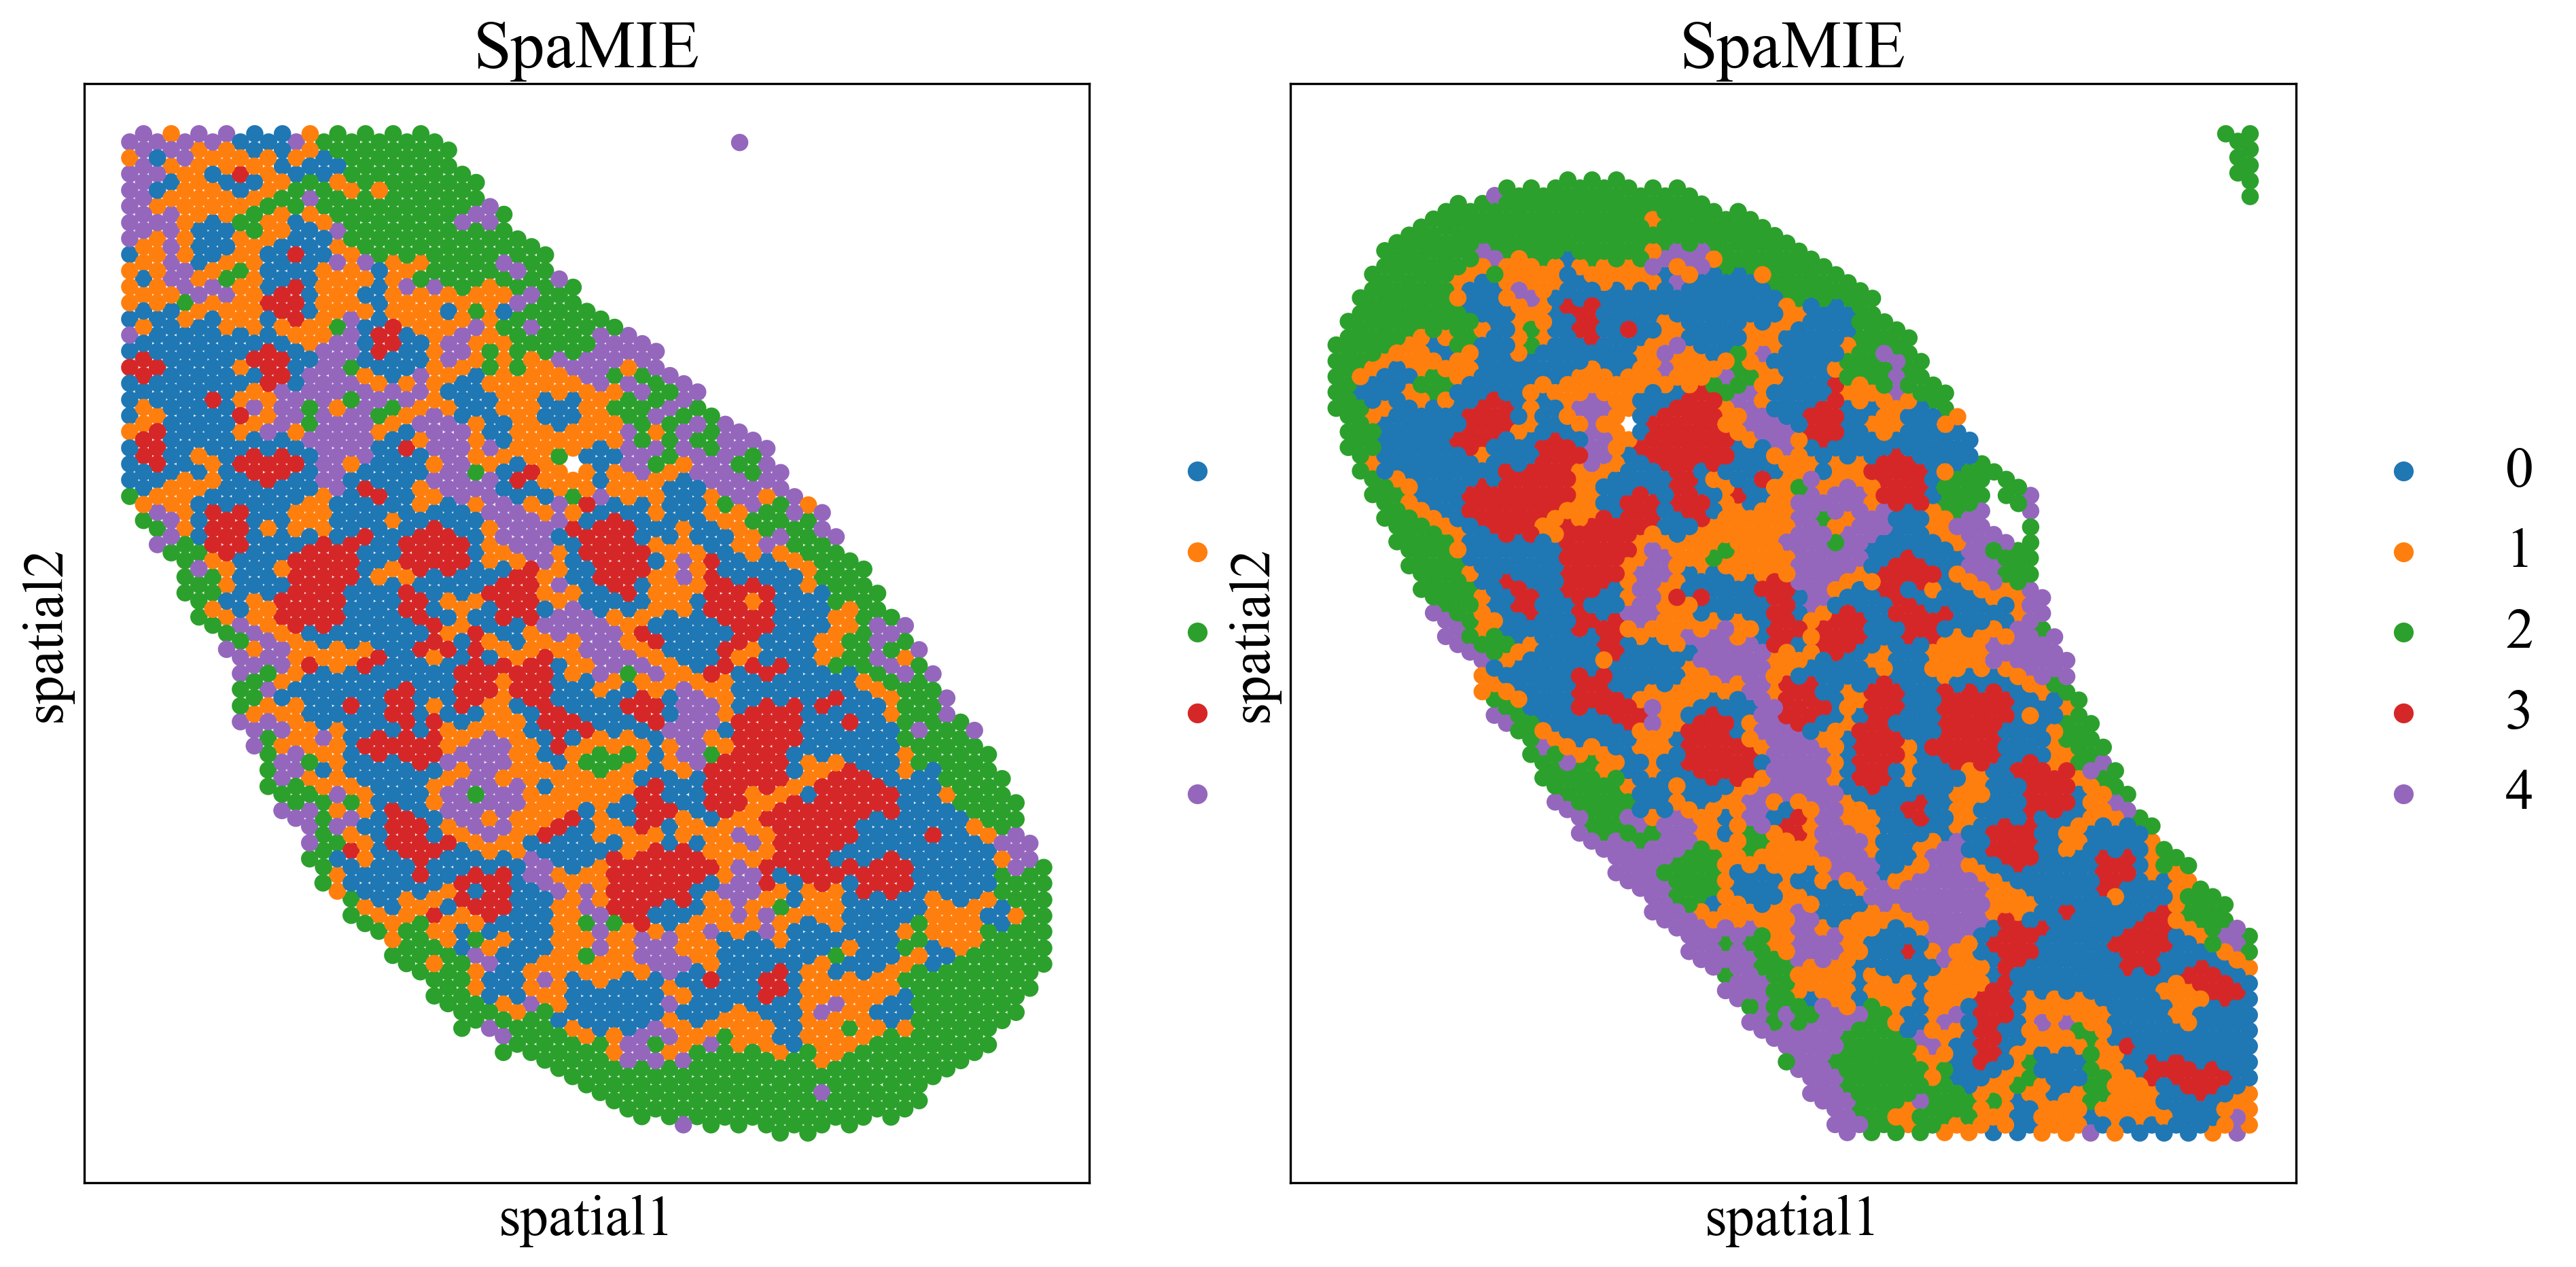

In [ ]:
path = '/data/xiangdw/data/data/spots/'
from SpatialGlue.utils import clustering
fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=300)
plt.rcParams['font.size'] = 20
tool = 'louvain'
adata = sc.read_h5ad(path + "MouseSpleen_concat_methods.h5ad")
clustering(adata_omics2, key='SpaMIE', add_key='SpaMIE',start=0.001, end=1, increment=0.1, n_clusters=5, method=tool, use_pca=False)
adata.obsm['SpaMIE'] = adata_omics2.obs['SpaMIE'].copy()
adata1 = adata[adata.obs['batch'] == '1'].copy()
adata2 = adata[adata.obs['batch'] == '1'].copy()
sc.pl.embedding(adata1, basis='spatial', color=['SpaMIE'], ax=axs[0], title='SpaMIE', s=150, show=False)
sc.pl.embedding(adata2, basis='spatial', color=['SpaMIE'], ax=axs[1], title='SpaMIE', s=150, show=False)